## IMPORT DATA

we import the dataset already with the feature enhancement, climate data, macro-economical variables.
In particular we enhanced with:
- features from one-hot encoded variables (years, countries, sectors), so to differentiate among them
- features on local geographical effects - considering macroeconomical and climate variables aggregates in ranges of 60 and 150 km. The distance was decided through averaging the centroids distances in Europe
- Aggregation of climate data to yearly granularity so to be able to compound the two datasets. In order to better integrate in the models such variables, we used max, mean and sum of the monthly observations

In [1]:
import pandas as pd
import numpy as np
import math 
import json
import time 
import datetime
from collections import Counter 
from datetime import datetime,timedelta
import requests
import os
import pandas as pd
import time
from io import BytesIO

pd.options.display.max_rows = 200
pd.options.display.max_columns = 300

ecoclim = pd.read_excel("Economic_climate_data_2001_2022_yearly.xlsx")
ecoclim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44534 entries, 0 to 44533
Data columns (total 94 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            44534 non-null  int64  
 1   geo                                   44534 non-null  object 
 2   year                                  44534 non-null  int64  
 3   sector                                44534 non-null  object 
 4   employment                            44533 non-null  float64
 5   gross value added                     44534 non-null  float64
 6   area                                  44534 non-null  float64
 7   gdp                                   44534 non-null  float64
 8   population                            44492 non-null  float64
 9   country                               44534 non-null  object 
 10  regions_within_60km                   44534 non-null  object 
 11  regions_within_

In [2]:
#drop all variables with NaN that were not imputed in the preprocessing steps

ecoclim.info()
ecoclim.dropna(axis = 1, inplace = True)
ecoclim.columns = ecoclim.columns.astype(str)

ecoclim

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44534 entries, 0 to 44533
Data columns (total 94 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            44534 non-null  int64  
 1   geo                                   44534 non-null  object 
 2   year                                  44534 non-null  int64  
 3   sector                                44534 non-null  object 
 4   employment                            44533 non-null  float64
 5   gross value added                     44534 non-null  float64
 6   area                                  44534 non-null  float64
 7   gdp                                   44534 non-null  float64
 8   population                            44492 non-null  float64
 9   country                               44534 non-null  object 
 10  regions_within_60km                   44534 non-null  object 
 11  regions_within_

Unnamed: 0    geo  year sector  gross value added         area  \
0               0  AT111  2002      A              37.00   668.166746   
1               1  AT111  2003      A              55.00   668.166746   
2               2  AT111  2004      A              45.00   668.166746   
3               3  AT111  2005      A              34.00   668.166746   
4               4  AT111  2006      A              37.00   668.166746   
...           ...    ...   ...    ...                ...          ...   
44529       44529  SK042  2017      C            2258.92  6754.000000   
44530       44530  SK042  2018      C            2486.22  6754.000000   
44531       44531  SK042  2019      C            2546.43  6754.000000   
44532       44532  SK042  2020      C            2337.87  6754.000000   
44533       44533  SK042  2021      C            2835.63  6754.000000   

            gdp country regions_within_60km  \
0        627.48      AT   ['AT11', 'AT111']   
1        674.62      AT   ['AT11', 'AT111']   
2        676.25      AT   ['AT11', 'AT111']   
3        669.25      AT   ['AT11', 'AT111']   
4        714.72      AT   ['AT11', 'AT111']   
...         ...     ...                 ...   
44529  10334.60      SK   ['SK04', 'SK042']   
44530  10702.43      SK   ['SK04', 'SK042']   
44531  11069.07      SK   ['SK04', 'SK042']   
44532  11290.92      SK   ['SK04', 'SK042']   
44533  12042.57      SK   ['SK04', 'SK042']   

                                    regions_within_150km    empl150  \
0      ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...   7.513750   
1      ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...   7.132500   
2      ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...   6.841875   
3      ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...   6.599375   
4      ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...   6.401875   
...                                                  ...        ...   
44529  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  52.645000   
44530  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  53.612500   
44531  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  54.080000   
44532  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  52.455000   
44533  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  35.406667   

            gdp150  AT  BE  BG  CY  CZ  DE  DK  EE  EL  ES  FI  FR  HR  HU  \
0      7678.171250   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
1      7862.706875   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
2      8225.823125   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
3      8587.190625   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
4      9032.411875   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
...            ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
44529  7088.242500   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
44530  7587.610000   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
44531  7797.480000   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
44532  7696.697500   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
44533  8355.000000   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

       IE  IT  LT  LU  LV  MT  NL  PL  PT  RO  SE  SI  SK  2002  2003  2004  \
0       0   0   0   0   0   0   0   0   0   0   0   0   0     1     0     0   
1       0   0   0   0   0   0   0   0   0   0   0   0   0     0     1     0   
2       0   0   0   0   0   0   0   0   0   0   0   0   0     0     0     1   
3       0   0   0   0   0   0   0   0   0   0   0   0   0     0     0     0   
4       0   0   0   0   0   0   0   0   0   0   0   0   0     0     0     0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   ...   ...   ...   
44529   0   0   0   0   0   0   0   0   0   0   0   0   1     0     0     0   
44530   0   0   0   0   0   0   0   0   0   0   0   0   1     0     0     0   
44531   0   0   0   0   0   0   0   0   0   0   0   0   1     0 

# ML Models
## Train/Test set 
in this case we splitted the data in before 2019 and after, as we had to forecast such dataset.
In the ML models preparation with data up to 2018, we tested in a non-split way, so to better generalize the models (see file MachineLearning Models - preparation on 2018.ipynb)

## Models tests
We tested several models such as:
XGBoost Regressor
Random Forest Regressor
SARIMA
Prophet

XGBoost perform at best. We kept the setup that was identified through crossvalidation and setup setting

## Models evaluation
since the Kernel kept crashing, we are not able to compute the data country by country instead than on European level. From the preparation part of the models, as you can see from the feature importance, they heavily variate from country to country.

Our expectation is that, if in general the climate variables have little to no impact to most countries gross value added, for specific situations they do. In particular it's interesting to look into those years where catastrophic metereological/terrestrial events happened. If in general such variables don't have an impact at global level, they result to be much more valuable on local effects (yearly - monthly)

In [27]:

from sklearn.model_selection import train_test_split

#generic train test set
# X_train1, X_test1, y_train, y_test = train_test_split(ecoclim[list(set(ecoclim.columns.to_list()) - set(['geo',"_merge",'year', 'sector','country', 'gross value added','regions_within_60km', 'regions_within_150km']))], ecoclim["gross value added"].to_list())


#trainset < 2019 testset >=2019
# Splitting the data into training and testing sets based on the date
train = ecoclim[ecoclim['year'] <= 2018]  # Training set: up to year 2018
test = ecoclim[ecoclim['year'] >= 2019]   # Testing set: from year 2019 onwards

X_train1 = train[list(set(train.columns.to_list()) - set(['geo',"_merge",'year', 'sector','country', 'gross value added','regions_within_60km', 'regions_within_150km']))]
X_test1 = test[list(set(test.columns.to_list()) - set(['geo',"_merge",'year', 'sector','country', 'gross value added','regions_within_60km', 'regions_within_150km']))]
y_train = train["gross value added"].to_list()
y_test = test["gross value added"].to_list()
X_train1

PL  aggregate_heat_intensity_median_max  C  spi_06_median_max  CY  RO  \
0       0                            12.212358  0             1.1380   0   0   
1       0                             5.538332  0             1.6705   0   0   
2       0                             3.038550  0             1.6150   0   0   
3       0                             1.529521  0             1.2395   0   0   
4       0                             9.340811  0             1.2195   0   0   
...    ..                                  ... ..                ...  ..  ..   
44526   0                             8.886209  1             1.1010   0   0   
44527   0                            10.313092  1             0.6085   0   0   
44528   0                             3.064743  1             0.9855   0   0   
44529   0                             6.603099  1             1.1425   0   0   
44530   0                             3.128374  1             2.0210   0   0   

       spi_12_median_sum  2008  spi_06_median_mean  2017  2010  2018  2011  \
0               -11.8175     0           -0.332667     0     0     0     0   
1                -8.4440     0           -1.063125     0     0     0     0   
2                -6.2535     0           -0.021542     0     0     0     0   
3                -5.0490     0           -0.137125     0     0     0     0   
4                 7.9755     0            0.164250     0     0     0     0   
...                  ...   ...                 ...   ...   ...   ...   ...   
44526            -1.4810     0            0.293750     0     0     0     0   
44527            -6.1585     0           -0.897958     0     0     0     0   
44528            -3.7075     0            0.257417     0     0     0     0   
44529             3.1165     0            0.243833     1     0     0     0   
44530             6.4595     0            0.312750     0     0     1     0   

       heat_wave_count_max  SK  2009  HR  IT         area  LT  SE  LV  \
0                        3   0     0   0   0   668.166746   0   0   0   
1                        2   0     0   0   0   668.166746   0   0   0   
2                        2   0     0   0   0   668.166746   0   0   0   
3                        1   0     0   0   0   668.166746   0   0   0   
4                        2   0     0   0   0   668.166746   0   0   0   
...                    ...  ..   ...  ..  ..          ...  ..  ..  ..   
44526                    4   1     0   0   0  6754.000000   0   0   0   
44527                    3   1     0   0   0  6754.000000   0   0   0   
44528                    2   1     0   0   0  6754.000000   0   0   0   
44529                    3   1     0   0   0  6754.000000   0   0   0   
44530                    1   1     0   0   0  6754.000000   0   0   0   

       heat_wave_count_sum  spi_01_median_sum  IE  MT  BE  AT  2002  2020  \
0                        6             0.3535   0   0   0   1     1     0   
1                        4            -6.5405   0   0   0   1     0     0   
2                        3             0.0170   0   0   0   1     0     0   
3                        1             2.7245   0   0   0   1     0     0   
4                        2            -1.6175   0   0   0   1     0     0   
...                    ...                ...  ..  ..  ..  ..   ...   ...   
44526                    6             0.7635   0   0   0   0     0     0   
44527                    8            -4.2540   0   0   0   0     0     0   
44528                    4             2.2920   0   0   0   0     0     0   
44529                    3             2.9570   0   0   0   0     0     0   
44530                    3            -0.9575   0   0   0   0     0     0   

       heat_wave_count_mean  aggregate_heat_intensity_median_mean  2004  DK  \
0                  0.500000                              1.454209     0   0   
1                  0.333333                              0.861442     0   0   
2                  0.250000                              0.466513     

## Scikit Learn XGBOOST

In [13]:
#implementation with scikitlearn
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
   
}
xgb = GradientBoostingRegressor(**params)
xgb.fit(X_train1, y_train)
xgb.score(X_test1,y_test)
# print(y_test)
def perc_err(y_pred, y_true):
    abs_err = abs(y_pred - y_true)/y_pred
    sum_abs_err = np.sum(abs_err)
    loss = sum_abs_err / len(y_true) *100
    return loss

# print(xgb.predict(X_test1))
mse = sklearn.metrics.mean_squared_error(y_test, xgb.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print('RMSE for xgboost',max(0,rmse)) 
perc_err(xgb.predict(X_test1),y_test)



The mean squared error (MSE) on test set: 905548.5802
RMSE for xgboost 951.603163210129


42.980459215857344

## XGBOOST (better model)

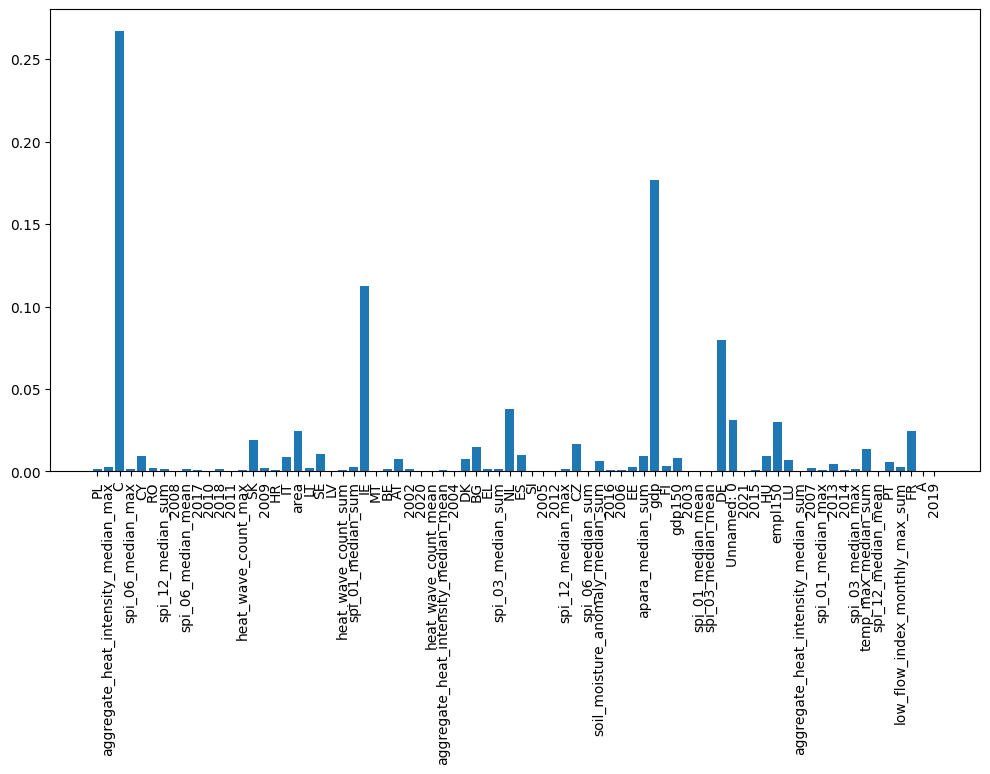

In [28]:

#implementation with XGBOOST library

from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot
# load data
# split data into X and y

# fit model no training data
model = XGBRegressor()
model.fit(X_train1, y_train)
# feature importance
# print(model.feature_importances_)
# plot
pyplot.figure(figsize=(12, 6))
pyplot.bar(X_train1.columns, model.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.show()





## Feature importance

it appears very clear as the the countries labels have a huge impact on the forecast (DE, IE) as much as the macroeconomical variables.
The climate variables have an impact at most of 1% on the overall forecast, as foreseen before.

In [32]:
# print(model.score(X_test1,y_test))
# print(y_test)
def perc_err(y_pred, y_true):
    abs_err = abs(y_pred - y_true)/y_pred
    sum_abs_err = np.sum(abs_err)
    loss = sum_abs_err / len(y_true) *100
    return loss

predicted = model.predict(X_test1)
mse = sklearn.metrics.mean_squared_error(y_test, model.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print('RMSE for xgboost',max(0,rmse)) 



The mean squared error (MSE) on test set: 439260.8585
RMSE for xgboost 662.7675750424017


In [38]:
test

Unnamed: 0    geo  year sector  gross value added    area       gdp  \
17             17  AT111  2019      A              37.00   701.0   1017.16   
18             18  AT111  2020      A              44.00   701.0   1007.22   
36             36  AT111  2019      C             152.00   701.0   1017.16   
37             37  AT111  2020      C             146.00   701.0   1007.22   
55             55  AT112  2019      A             153.00  1792.0   5452.85   
...           ...    ...   ...    ...                ...     ...       ...   
44512       44512  SK042  2020      A             183.78  6754.0  11290.92   
44513       44513  SK042  2021      A             208.22  6754.0  12042.57   
44531       44531  SK042  2019      C            2546.43  6754.0  11069.07   
44532       44532  SK042  2020      C            2337.87  6754.0  11290.92   
44533       44533  SK042  2021      C            2835.63  6754.0  12042.57   

      country         regions_within_60km  \
17         AT           ['AT11', 'AT111']   
18         AT           ['AT11', 'AT111']   
36         AT           ['AT11', 'AT111']   
37         AT           ['AT11', 'AT111']   
55         AT  ['AT11', 'AT112', 'AT127']   
...       ...                         ...   
44512      SK           ['SK04', 'SK042']   
44513      SK           ['SK04', 'SK042']   
44531      SK           ['SK04', 'SK042']   
44532      SK           ['SK04', 'SK042']   
44533      SK           ['SK04', 'SK042']   

                                    regions_within_150km    empl150  \
17     ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...   5.020000   
18     ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...   5.021250   
36     ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...  25.753125   
37     ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'AT111...  24.753750   
55     ['AT1', 'AT11', 'AT12', 'AT13', 'HU22', 'SK01'...   4.095385   
...                                                  ...        ...   
44512  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  11.480000   
44513  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  34.865000   
44531  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  54.080000   
44532  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  52.455000   
44533  ['HU31', 'SK04', 'HU311', 'HU323', 'SK041', 'S...  35.406667   

             gdp150  AT  BE  BG  CY  CZ  DE  DK  EE  EL  ES  FI  FR  HR  HU  \
17     13226.671250   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
18     12577.846875   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
36     13226.671250   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
37     12577.846875   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
55     15784.819231   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
...             ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
44512   7696.697500   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
44513   8355.000000   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
44531   7797.480000   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
44532   7696.697500   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
44533   8355.000000   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

       IE  IT  LT  LU  LV  MT  NL  PL  PT  RO  SE  SI  SK  2002  2003  2004  \
17      0   0   0   0   0   0   0   0   0   0   0   0   0     0     0     0   
18      0   0   0   0   0   0   0   0   0   0   0   0   0     0     0     0   
36      0   0   0   0   0   0   0   0   0   0   0   0   0     0     0     0   
37      0   0   0   0   0   0   0   0   0   0   0   0   0     0     0     0   
55      0   0   0   0   0   0   0   0   0   0   0   0   0     0     0     0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   ...   ...   ...   
44512   0   0   0   0   0   0   0   0   0   0   0   0   1     0     0     0   
44513   0   0   0   0   0   0   0   0   0   0   0   0   1     0     0     0   
44531   0   0   

In [43]:
pd.DataFrame(predicted, columns = ['predicted_value_gva'])

predicted_value_gva
0               84.420937
1               96.896141
2               48.602375
3              128.866669
4               90.317429
...                   ...
5139           143.204514
5140           788.852844
5141          1927.921997
5142          1892.465088
5143          1628.287720

[5144 rows x 1 columns]

In [54]:
final = pd.concat([test.reset_index(), pd.DataFrame(predicted, columns = ['predicted_value_gva'])], axis = 1)[["geo","year","sector","predicted_value_gva"]]
final = final.pivot(index=['geo',"year"], columns='sector', values='predicted_value_gva').reset_index()
final.columns = [ 'geo','year','gva_Agr','gva_Man']
final

geo  year     gva_Agr      gva_Man
0     AT111  2019   84.420937    48.602375
1     AT111  2020   96.896141   128.866669
2     AT112  2019   90.317429   480.381531
3     AT112  2020   91.087074   961.787781
4     AT113  2019   98.778831   707.913696
...     ...   ...         ...          ...
2567  SK041  2020  197.231659  1840.021973
2568  SK041  2021  661.285706   602.274048
2569  SK042  2019  342.089081  1927.921997
2570  SK042  2020  143.204514  1892.465088
2571  SK042  2021  788.852844  1628.287720

[2572 rows x 4 columns]

In [57]:
final.to_csv('Test_5.csv', index=False)

#final delivery

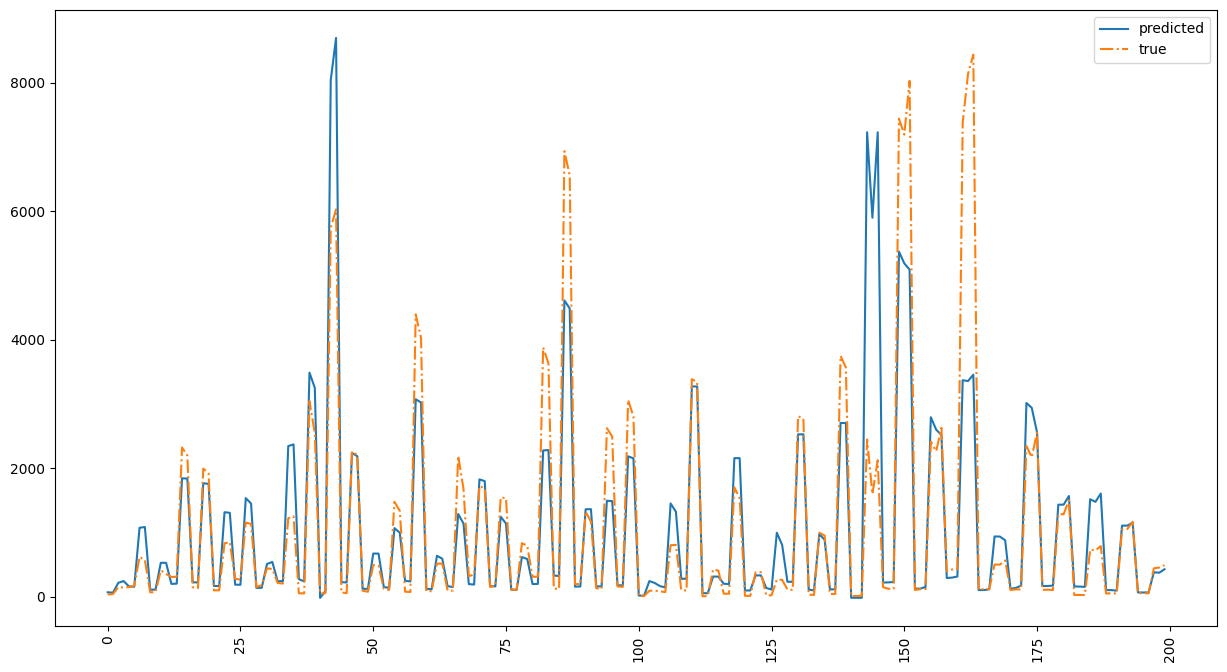

In [17]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (15,8))
plt.plot(range(X_test1.DE.head(200).count()), predicted[:200],label = "predicted")
plt.plot(range(X_test1.DE.head(200).count()), y_test[:200],'-.', label ='true')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

#examples on 200 samples from germany

In [ ]:
#parameters tuning for random forest regressor


import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = X_train1, y_train

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestRegressor(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestRegressor(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestRegressor(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 5
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

## XGBOOST by country

the models are much more accurate and it would be possible to make a better feature selection, which we didn't insert due to the crashing kernel.
XGBoost throws a weird error consequently, but we are able to plot interesting feature importance plots, which highlight interesting local factors.

AS mentioned before, some countries like __*Germany*__ have local climatic effects. In this case the heat waves max count matters significantly for the actual forecast (__*10%*__)

This is proof that in specific local cases the usage of such climate variables is meaningful and advisable

In [18]:
from sklearn.model_selection import train_test_split

#generic train test set
# X_train1, X_test1, y_train, y_test = train_test_split(ecoclim[list(set(ecoclim.columns.to_list()) - set(['geo',"_merge",'year', 'sector','country', 'gross value added','regions_within_60km', 'regions_within_150km']))], ecoclim["gross value added"].to_list())


#trainset < 2019 testset >=2019
# Splitting the data into training and testing sets based on the date
train = ecoclim[ecoclim['year'] <= 2018]  # Training set: up to year 2018
test = ecoclim[ecoclim['year'] >= 2019]   # Testing set: from year 2019 onwards


X_tr = []
X_te = []
y_tr = []
y_te = []

countries = ecoclim["country"].drop_duplicates().to_list()
for country in countries:
    
    X_train1 = train.loc[train['country'] == country ,list(set(train.columns.to_list()) - set(['geo','AT',
     'BE',
     'BG',
     'CY',
     'CZ',
     'DE',
     'DK',
     'EE',
     'EL',
     'ES',
     'FI',
     'FR',
     'HR',
     'HU',
     'IE',
     'IT',
     'LT',
     'LU',
     'LV',
     'MT',
     'NL',
     'PL',                                                                                
     'PT',
     'RO',
     'SE',
     'SI',
     'SK',"_merge",'year', 'sector', 'gross value added','regions_within_60km', 'regions_within_150km']))]

    X_test1 = test.loc[test['country'] == country ,list(set(test.columns.to_list()) - set(['geo','AT',
     'BE',
     'BG',
     'CY',
     'CZ',
     'DE',
     'DK',
     'EE',
     'EL',
     'ES',
     'FI',
     'FR',
     'HR',
     'HU',
     'IE',
     'IT',
     'LT',
     'LU',
     'LV',
     'MT',
     'NL',
     'PL',                                                                                
     'PT',
     'RO',
     'SE',
     'SI',
     'SK',"_merge",'year', 'sector', 'gross value added','regions_within_60km', 'regions_within_150km']))]
    y_train = train.loc[train['country'] == country ,"gross value added"].to_list()
    y_test = test.loc[test['country'] == country ,"gross value added"].to_list()
    X_tr.append(X_train1)
    X_te.append(X_test1)
    y_tr.append(y_train)
    y_te.append(y_test)

In [19]:
X_tr[1]

aggregate_heat_intensity_median_max        gdp150  C  2003  \
1330                             2.209910   9459.941892  0     1   
1331                            14.823619   9936.762162  0     0   
1332                            10.931926  10354.412973  0     0   
1333                             2.715830  10853.768108  0     0   
1334                            13.865951  11473.043514  0     0   
...                                   ...           ... ..   ...   
2834                             1.927639  11624.838750  1     0   
2835                            10.919014  12005.505625  1     0   
2836                             6.682722  12332.887500  1     0   
2837                             4.434966  10470.505455  1     0   
2838                             6.818029  10852.145909  1     0   

      spi_06_median_max  spi_01_median_mean  spi_03_median_mean  \
1330              0.906           -0.317917           -0.490833   
1331             -0.033           -0.093083           -0.191167   
1332              0.321           -0.223000           -0.380583   
1333              1.056           -0.056083           -0.144667   
1334              1.518            0.139833            0.372083   
...                 ...                 ...                 ...   
2834              1.156            0.115667            0.205833   
2835              0.771           -0.160500           -0.272500   
2836              2.458            0.046333            0.177917   
2837              0.760           -0.060583           -0.514333   
2838              1.077           -0.271583           -0.379083   

      spi_12_median_sum  2008  Unnamed: 0  spi_06_median_mean  2017  2010  \
1330             -0.941     0        1330           -0.388750     0     0   
1331             -8.251     0        1331           -0.375583     0     0   
1332             -9.417     0        1332           -0.447083     0     0   
1333             -7.464     0        1333           -0.311833     0     0   
1334              7.323     0        1334            0.632083     0     0   
...                 ...   ...         ...                 ...   ...   ...   
2834              1.491     0        2834            0.332500     0     0   
2835              0.120     0        2835           -0.342250     0     0   
2836              7.594     0        2836            0.599083     0     0   
2837            -16.516     0        2837           -1.026583     1     0   
2838             -0.659     0        2838           -0.431833     0     0   

      2018  2021  2011  heat_wave_count_max  2015  2009        area  \
1330     0     0     0                    1     0     0  158.893333   
1331     0     0     0                    4     0     0  158.893333   
1332     0     0     0                    4     0     0  158.893333   
1333     0     0     0                    2     0     0  158.893333   
1334     0     0     0                    5     0     0  158.893333   
...    ...   ...   ...                  ...   ...   ...         ...   
2834     0     0     0                    1     0     0  911.000000   
2835     0     0     0                    5     1     0  911.000000   
2836     0     0     0                    2     0     0  911.000000   
2837     0     0     0                    1     0     0  911.000000   
2838     1     0     0                    2     0     0  911.000000   

      heat_wave_count_sum  spi_01_median_sum   empl150  \
1330                    1             -3.815  2.595135   
1331                    4             -1.117  2.588378   
1332                    4             -2.676  2.549730   
1333                    4             -0.673  2.464595   
1334                    7              1.678  2.423784   
...                   ...                ...       ...   
2834                    2              1.388  9.266250   
2835                   11             -1.926  8.936875   
2836                    4              0.556  8.873125   
2837                    1 

<class 'pandas.core.frame.DataFrame'>
Index: 13634 entries, 4506 to 19741
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   aggregate_heat_intensity_median_max   13634 non-null  float64
 1   gdp150                                13634 non-null  float64
 2   C                                     13634 non-null  int64  
 3   2003                                  13634 non-null  int64  
 4   spi_06_median_max                     13634 non-null  float64
 5   spi_01_median_mean                    13634 non-null  float64
 6   spi_03_median_mean                    13634 non-null  float64
 7   spi_12_median_sum                     13634 non-null  float64
 8   2008                                  13634 non-null  int64  
 9   Unnamed: 0                            13634 non-null  int64  
 10  spi_06_median_mean                    13634 non-null  float64
 11  2017             

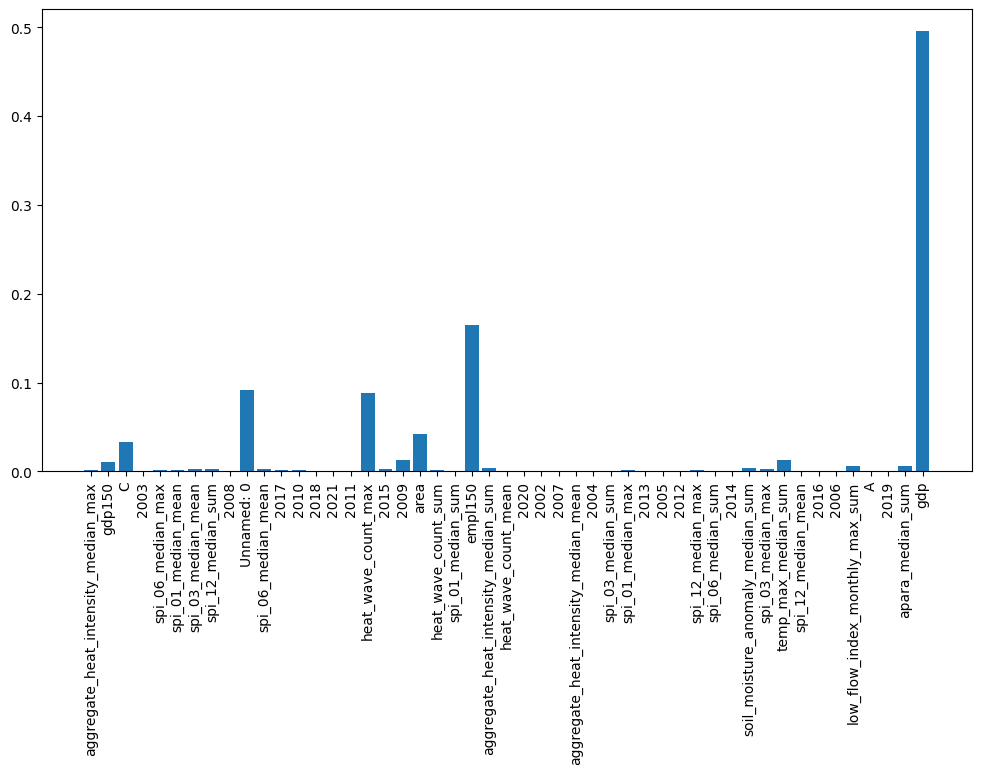

aggregate_heat_intensity_median_max   0.0017461354
gdp150   0.010225629
C   0.03286752
2003   0.000330304
spi_06_median_max   0.0011798008
spi_01_median_mean   0.0016344049
spi_03_median_mean   0.0025075045
spi_12_median_sum   0.0022203354
2008   0.0004837923
Unnamed: 0   0.09173451
spi_06_median_mean   0.0023117329
2017   0.0014086119
2010   0.0014751493
2018   0.0
2021   0.0
2011   0.0007485284
heat_wave_count_max   0.08857236
2015   0.0023227406
2009   0.01291971
area   0.0416516
heat_wave_count_sum   0.0010808215
spi_01_median_sum   0.0
empl150   0.16510974
aggregate_heat_intensity_median_sum   0.0033618992
heat_wave_count_mean   0.0
2020   0.0
2002   0.0007935323
2007   0.0007238372
aggregate_heat_intensity_median_mean   0.0
2004   0.00019495882
spi_03_median_sum   0.0
spi_01_median_max   0.0011707422
2013   0.0006537034
2005   0.000450867
2012   0.00058318063
spi_12_median_max   0.0016455988
spi_06_median_sum   0.0
2014   0.00049315806
soil_moisture_anomaly_median_sum   0.0033215

XGBoostError: [14:55:58] /workspace/src/c_api/c_api.cc:651: DMatrix/Booster has not been initialized or has already been disposed.
Stack trace:
  [bt] (0) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x15c2ca) [0x7f466bbf02ca]
  [bt] (1) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGDMatrixGetStrFeatureInfo+0x33f) [0x7f466bbfe11f]
  [bt] (2) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f47245dca4a]
  [bt] (3) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f47245dbfea]
  [bt] (4) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x12461) [0x7f472466b461]
  [bt] (5) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x86eb) [0x7f47246616eb]
  [bt] (6) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(_PyObject_MakeTpCall+0x26b) [0x55b2cb89ba6b]
  [bt] (7) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(_PyEval_EvalFrameDefault+0x54a6) [0x55b2cb8979d6]
  [bt] (8) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(+0x14f299) [0x55b2cb8ad299]



In [21]:
i= 5
# ['AT',
#  'BE',
#  'BG',
#  'CY',
#  'CZ',
#  'DE',
country = "DE"
model = XGBRegressor()
df = X_tr[i]
df = df.drop(columns = ["country"])
df.info()
model.fit(df, y_tr[i])
pyplot.figure(figsize=(12, 6))
pyplot.bar(df.columns, model.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.show()
for k, j  in zip(df.columns, model.feature_importances_):
    print(str(k) + "   " + str(j))

import sklearn
predicted = model.predict(X_te[i].drop(columns = ["country"], inplace = True))
mse = sklearn.metrics.mean_squared_error(y_te[i], model.predict(X_te[i].drop(columns = ["country"], inplace = True)))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print('RMSE for xgboost ' + country + "    ",max(0,rmse)) 
# perc_err(model.predict(X_test1),y_test)


<class 'pandas.core.frame.DataFrame'>
Index: 1248 entries, 1330 to 2838
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   aggregate_heat_intensity_median_max   1248 non-null   float64
 1   gdp150                                1248 non-null   float64
 2   C                                     1248 non-null   int64  
 3   2003                                  1248 non-null   int64  
 4   spi_06_median_max                     1248 non-null   float64
 5   spi_01_median_mean                    1248 non-null   float64
 6   spi_03_median_mean                    1248 non-null   float64
 7   spi_12_median_sum                     1248 non-null   float64
 8   2008                                  1248 non-null   int64  
 9   Unnamed: 0                            1248 non-null   int64  
 10  spi_06_median_mean                    1248 non-null   float64
 11  2017               

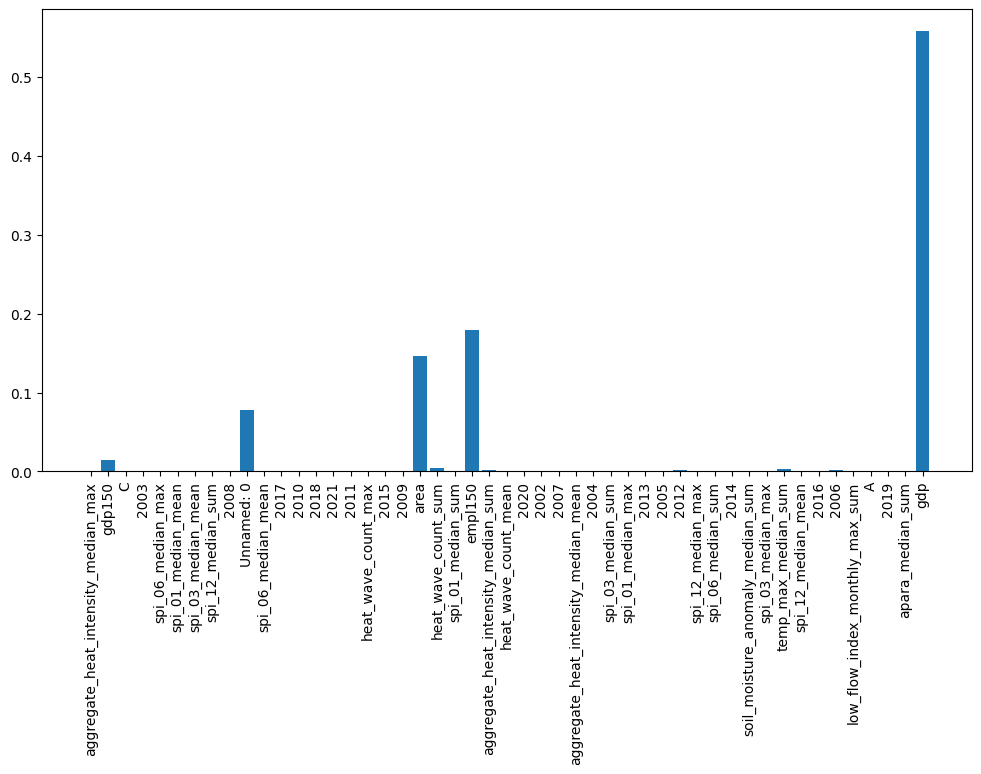

aggregate_heat_intensity_median_max   0.0004709031
gdp150   0.014205254
C   0.00073401514
2003   2.7621541e-05
spi_06_median_max   0.00046266755
spi_01_median_mean   0.00036335387
spi_03_median_mean   0.000515678
spi_12_median_sum   0.00056324794
2008   0.0005350268
Unnamed: 0   0.07834778
spi_06_median_mean   0.00023946352
2017   0.0004507814
2010   0.0009268945
2018   0.00027771457
2021   0.0
2011   0.0001775534
heat_wave_count_max   0.0004519618
2015   1.6705751e-06
2009   3.9741903e-05
area   0.14646253
heat_wave_count_sum   0.004613487
spi_01_median_sum   0.0
empl150   0.17986113
aggregate_heat_intensity_median_sum   0.0019002383
heat_wave_count_mean   0.0
2020   0.0
2002   0.0
2007   0.00017583015
aggregate_heat_intensity_median_mean   0.0
2004   0.0
spi_03_median_sum   0.0
spi_01_median_max   0.00069267
2013   0.00019038834
2005   1.66523e-05
2012   0.0017819339
spi_12_median_max   0.00051094976
spi_06_median_sum   0.0
2014   3.4527022e-06
soil_moisture_anomaly_median_sum   0.00

XGBoostError: [14:58:08] /workspace/src/c_api/c_api.cc:651: DMatrix/Booster has not been initialized or has already been disposed.
Stack trace:
  [bt] (0) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x15c2ca) [0x7f466bbf02ca]
  [bt] (1) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGDMatrixGetStrFeatureInfo+0x33f) [0x7f466bbfe11f]
  [bt] (2) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f47245dca4a]
  [bt] (3) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f47245dbfea]
  [bt] (4) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x12461) [0x7f472466b461]
  [bt] (5) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x86eb) [0x7f47246616eb]
  [bt] (6) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(_PyObject_MakeTpCall+0x26b) [0x55b2cb89ba6b]
  [bt] (7) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(_PyEval_EvalFrameDefault+0x54a6) [0x55b2cb8979d6]
  [bt] (8) /home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/python_hackathon_3.10/bin/python(+0x14f299) [0x55b2cb8ad299]



In [25]:
i= 1
country = "BE"
model = XGBRegressor()
df = X_tr[i]
df = df.drop(columns = ["country"])
df.info()
model.fit(df, y_tr[i])
pyplot.figure(figsize=(12, 6))
pyplot.bar(df.columns, model.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.show()
for k, j  in zip(df.columns, model.feature_importances_):
    print(str(k) + "   " + str(j))

import sklearn
predicted = model.predict(X_te[i].drop(columns = ["country"], inplace = True))
mse = sklearn.metrics.mean_squared_error(y_te[i], model.predict(X_te[i].drop(columns = ["country"], inplace = True)))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print('RMSE for xgboost ' + country + "    ",max(0,rmse)) 
# perc_err(model.predict(X_test1),y_test)


In [22]:
i= 0
country = "AT"
model = XGBRegressor()
df = X_tr[i]
df = df.drop(columns = ["country"])
df.info()
model.fit(df, y_tr[i])


<class 'pandas.core.frame.DataFrame'>
Index: 1190 entries, 0 to 1327
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   aggregate_heat_intensity_median_max   1190 non-null   float64
 1   gdp150                                1190 non-null   float64
 2   C                                     1190 non-null   int64  
 3   2003                                  1190 non-null   int64  
 4   spi_06_median_max                     1190 non-null   float64
 5   spi_01_median_mean                    1190 non-null   float64
 6   spi_03_median_mean                    1190 non-null   float64
 7   spi_12_median_sum                     1190 non-null   float64
 8   2008                                  1190 non-null   int64  
 9   Unnamed: 0                            1190 non-null   int64  
 10  spi_06_median_mean                    1190 non-null   float64
 11  2017                  

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

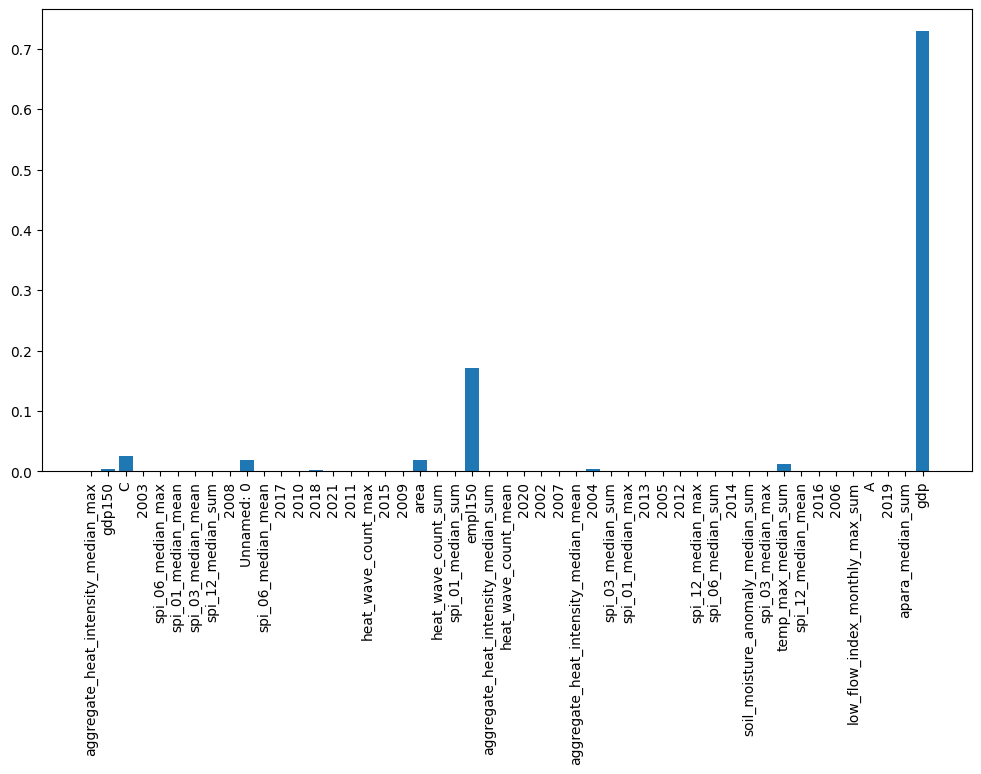

aggregate_heat_intensity_median_max   7.952609e-05
gdp150   0.004590976
C   0.02612392
2003   1.5744843e-06
spi_06_median_max   0.00043213274
spi_01_median_mean   0.00025599755
spi_03_median_mean   0.00095026207
spi_12_median_sum   0.0006234033
2008   2.8011875e-05
Unnamed: 0   0.018780185
spi_06_median_mean   0.00033523413
2017   0.00017507882
2010   0.00027041198
2018   0.0025835691
2021   0.0
2011   4.9419377e-05
heat_wave_count_max   0.00026901998
2015   0.0004691107
2009   0.00010406766
area   0.018927254
heat_wave_count_sum   0.00039118927
spi_01_median_sum   0.0
empl150   0.1720635
aggregate_heat_intensity_median_sum   0.00014959546
heat_wave_count_mean   0.0
2020   0.0
2002   0.000116341915
2007   0.00043391943
aggregate_heat_intensity_median_mean   0.0
2004   0.0038351458
spi_03_median_sum   0.0
spi_01_median_max   0.0004194683
2013   7.2668874e-05
2005   0.0013846688
2012   9.5551586e-05
spi_12_median_max   0.00021370417
spi_06_median_sum   0.0
2014   5.3009928e-05
soil_moist

In [23]:
pyplot.figure(figsize=(12, 6))
pyplot.bar(df.columns, model.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.show()
for k, j  in zip(df.columns, model.feature_importances_):
    print(str(k) + "   " + str(j))

In [ ]:
import sklearn
predicted = model.predict(X_te[i])#.drop(columns = ["country"], inplace = True))
mse = sklearn.metrics.mean_squared_error(y_te[i], model.predict(X_te[i]))#.drop(columns = ["country"], inplace = True)))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = math.sqrt(mse)
print('RMSE for xgboost ' + country + "    ",max(0,rmse)) 
# perc_err(model.predict(X_test1),y_test)


In [ ]:
model_list = []
for i, country in enumerate(countries):
    # fit model no training data
    model = XGBRegressor()
    model.fit(X_tr[i].drop(columns = ["country"], inplace = True), y_tr[i])
    model_list.append(model)
    pyplot.figure(figsize=(12, 6))
    pyplot.bar(X_tr[i].columns, model.feature_importances_)
    pyplot.xticks(rotation=90)
    pyplot.show()

#     predicted = xgb.predict(X_te[i].drop(columns = ["country"], inplace = True))
#     mse = sklearn.metrics.mean_squared_error(y_te[i], model.predict(X_te[i].drop(columns = ["country"], inplace = True)))
#     print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
#     rmse = math.sqrt(mse)
#     print('RMSE for xgboost ' + country + "    ",max(0,rmse)) 
#     # perc_err(model.predict(X_test1),y_test)

